#### NOTE ABOUT THE PSD CALCULATIONS
Throwing away steps 4, 5 from each optic because they have a strange defocus component.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
#load modules
import numpy as np
np.set_printoptions(suppress=True) # scientific notation gets annoying
import matplotlib.pyplot as plt
import matplotlib
from astropy import units as u
from astropy.io import fits
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.ndimage

# draw the dark hole regions
from skimage.draw import draw

# PSD code
import h5py
import copy

# import personal code
from model_kit import psd_functions as psd
from model_kit import datafiles as dfx
from model_kit import zernike as zern
from model_kit import dust
import poppy

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from datetime import datetime
date_ran = datetime.now()
dr_str = date_ran.strftime("%d/%m/%Y %H:%M:%S")
print('Last date this notebook has been ran: {0}'.format(dr_str))

Last date this notebook has been ran: 07/10/2020 21:29:40


In [2]:
# initialize the data
tot_fm = 1
tot_step= 4 # the last 2 step sets are bad news 
fits_folder = 'flat_mirrors/fixed_fits/'
raw_folder = 'flat_mirrors/2018_03_23/'

opt_parms = {'ca' : 80, # of the 80% CA given
             'ovs': 4096,
             'diam_100CA': 12.5*u.mm,
             'label': '0p5in',
             'ring_width': 5,
             'kmid_ll': 0.1/u.mm,
             'khigh_ll': 1/u.mm}

for fmn in range(0, tot_fm):
    fm_num = fmn+1
    for ns in range(0, tot_step):
        # call in the file
        fm_loc = raw_folder+'flat_{0}_n{1}_100percent_step{2}.datx'.format(opt_parms['label'],fm_num, ns)
        surf, mask, sp = dfx.open_datx(datx_file_loc=fm_loc, diam_ca100=opt_parms['diam_100CA'])
        wavelen = sp['value'][sp['label'].index('wavelen')] # should be same for all steps
        latres = sp['value'][sp['label'].index('latres')]

        if ns==0 and fmn==0:
            opt_parms['surf_units'] = sp['value'][sp['label'].index('surfunit')]
            opt_parms['wavelen'] = wavelen
            opt_parms['latres'] = latres
        
        # tighten up the matrix by removing empty rows and columns
        surf, mask = dfx.mat_tight(surf, mask)

        # apply a resize
        surf, mask = dfx.reduce_ca(data=surf, mask=mask, old_ca=100, new_ca=opt_parms['ca']) 
        # write data to a matrix
        if ns==0 and fmn==0: # initialize first time
            opt_parms['diam_ca'] = mask.shape[0]*latres.to(u.mm/u.pix)*u.pix
            data_set = np.zeros((tot_fm, tot_step, mask.shape[0], mask.shape[0])) # initialize
        data_set[fmn, ns, :, :] = surf.value

    print('Completed flat mirror n{0} file opening to local environment'.format(fm_num))
            
raw_surf = data_set * surf.unit
raw_mask = mask

Completed flat mirror n1 file opening to local environment


In [3]:
# create all the dust maps
# center of dust
dcen_x = ([[  61, 131, 196,   0],#    0,   0],
           [   9,  78, 145,   0],#    0,   0],
           [   0,   0,  39, 108]])#,  176,   0],
           #[   0,   0,   0,   0],#   78, 147],
           #[   0,   0,   0,   0]])#,    0,  23]])
dcen_y = [77, 109, 55]#, 156, 79]
dust_radius=25 # oversize for everyone, not many pixels to lose

# build dust lists
dust_set = np.zeros_like(data_set)

# Build Zernike listing
zm_cor_ptt = np.zeros_like(data_set)
nt_ptt = 3

# This loop masks the dust per step for all the optics
for nf in range(0, tot_fm): # choose optic
    fm_num = nf+1
    opt_parms['fm_num'] = nf+1
    
    # build all dust mask
    all_dust = np.ones((tot_step, mask.shape[0], mask.shape[1]))
    
    # analyzing per step
    for ns in range(0, tot_step):
        opt_parms['step_num'] = ns
        mask_step = np.ones_like(mask).astype(float) # initialize step mask
        
        # build each dust location at the step
        for nd in range(0, np.shape(dcen_x)[0]): 
            dmc = np.zeros_like(mask)
            if dcen_x[nd][ns] != 0: # if there is a value, then make a mask. Otherwise, skip.
                dm_coord = draw.circle(r=dcen_y[nd]-1, 
                                       c=dcen_x[nd][ns]-1,
                                       radius=dust_radius, shape=mask.shape)
                dmc[dm_coord] = True
            mask_step[dmc==True] = 0 #np.nan
        all_dust[ns] = mask_step * mask
        
        # for the dust mask made in the optic and step, remove the Zernike of surface.
        zm_cor_ptt[nf][ns] = dfx.apply_zern_arb(raw_surf = raw_surf[nf][ns], 
                                                dust_mask = all_dust[ns],
                                                nt = nt_ptt,
                                                opt_parms = opt_parms,
                                                write_file = True, 
                                                folder_loc=fits_folder).value        
        
    # Save the dust information
    dust_set[nf] = all_dust
    #print('-------------------')
    print('Dust masked and surface with Z{0} removed for all steps in n{1}'.format(nt_ptt, nf+1))

# apply the units for the zernike surface
zm_cor_ptt = zm_cor_ptt * raw_surf.unit

# remove the terms from the dictionary, only temporary
del opt_parms['fm_num']
del opt_parms['step_num']

Dust masked and surface with Z3 removed for all steps in n1


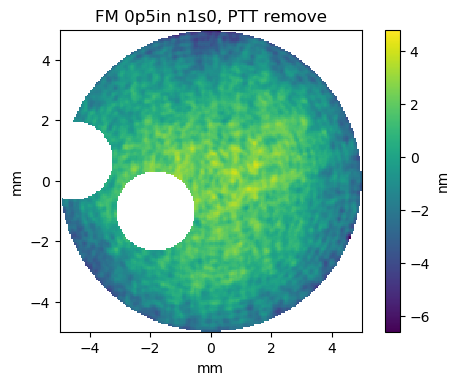

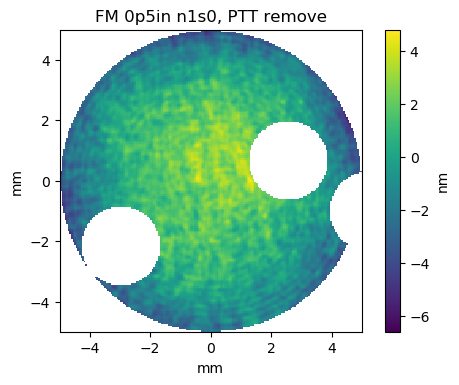

In [4]:
fmn1 = 0
sn1 = 0
fmn2 = 0
sn2 = 2

data1 = zm_cor_ptt[fmn1][sn1].to(u.nm)
data2 = zm_cor_ptt[fmn2][sn2].to(u.nm)

data1_sn = dfx.sn_map(surface=data1.value, mask=dust_set[fmn1][sn1])
data2_sn = dfx.sn_map(surface=data2.value, mask=dust_set[fmn2][sn2])

vmin = np.amin([np.amin(data1.value), np.amin(data2.value)])
vmax = np.amax([np.amax(data1.value), np.amax(data2.value)])

dfx.show_image(data=data1_sn,
              data_unit = data1.unit,
              pixscale=(latres*u.pix).to(u.mm),
              fig_title='FM {0} n{1}s{2}, PTT remove'.format(opt_parms['label'], fmn1+1, sn1),
              cbar_lim=[vmin, vmax])

dfx.show_image(data=data2_sn,
              data_unit = data2.unit,
              pixscale=(latres*u.pix).to(u.mm),
              fig_title='FM {0} n{1}s{2}, PTT remove'.format(opt_parms['label'], fmn1+1, sn1),
              cbar_lim=[vmin, vmax])

In [6]:
%%time
# do all the radial calculations
# call in the PSDs and take the radial profiles
# PSDs are calculated in separate script because it can take forever
nt_ptt = 3
psd_folder = 'flat_mirrors/mvls_psd/'
pos_count = 0
psd_avg = np.zeros_like(mask)
for nf in range(0, tot_fm): # choose optic
    fm_num = nf+1
    
    for ns in range(0, tot_step):
        mvls_name = 'lspsd_fm_{0}_n{1}_step{2}_z{3}.fits'.format(opt_parms['label'],fm_num,ns,nt_ptt)
        fm_psd_fits = fits.open(psd_folder+mvls_name)[0]
        psd_avg = psd_avg + fm_psd_fits.data # unitless for now
        fm_psd = fm_psd_fits.data * (u.nm*u.mm)**2 # manually place in the data
        fm_dk = fm_psd_fits.header['delta_k'] / u.mm

        # build the radial frequency
        cen = int(fm_psd.shape[0]/2)
        radial_freq = np.linspace(-cen, cen-1, cen*2) * fm_dk
        radial_freq = radial_freq[cen:cen*2].value

        # calculate the radial PSD data
        k_radial, psd_radial = psd.new_psd_radial(psd_data=fm_psd, radial_freq=radial_freq)

        # initialize all the variables
        if ns==0 and nf == 0:
            ptt_k_radial = np.zeros((tot_fm, tot_step, len(k_radial)))
            ptt_psd_radial = np.zeros_like(ptt_k_radial)
        
        ptt_k_radial[nf][ns] = np.asarray(k_radial)
        ptt_psd_radial[nf][ns] = np.asarray(psd_radial)

# apply units
ptt_k_radial = ptt_k_radial * fm_dk.unit
ptt_psd_radial = ptt_psd_radial * fm_psd.unit

# Calculate the average
psd_avg = (psd_avg / (tot_fm*tot_step)) * fm_psd.unit
ptt_avg_k_radial, ptt_avg_psd_radial = psd.new_psd_radial(psd_data=psd_avg, radial_freq=radial_freq)

CPU times: user 144 ms, sys: 4.26 ms, total: 148 ms
Wall time: 148 ms


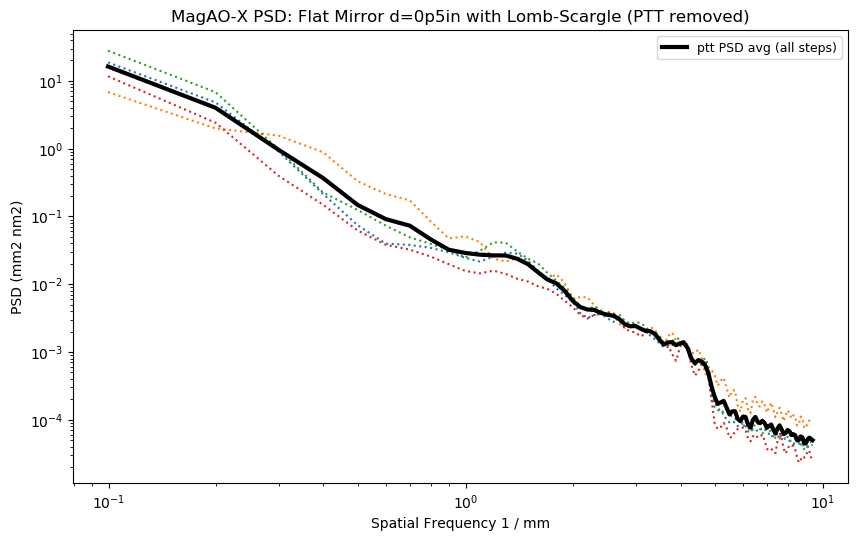

In [7]:
plt.figure(figsize=[10,6], dpi=100)
for nf in range(0, tot_fm):
    for ns in range(0, tot_step):
        plt.loglog(ptt_k_radial[nf][ns].value, ptt_psd_radial[nf][ns].value, ':')#, label='ptt n{1}_s{2}'.format(nt, nf,ns))
plt.loglog(ptt_avg_k_radial, ptt_avg_psd_radial, 'k', linewidth=3, label='ptt PSD avg (all steps)')
plt.xlabel('Spatial Frequency {0}'.format(fm_dk.unit))
plt.ylabel('PSD ({0})'.format(fm_psd.unit))
plt.title('MagAO-X PSD: Flat Mirror d={0} with Lomb-Scargle (PTT removed)'.format(opt_parms['label']))
plt.legend(prop={'size':9})#,loc='center left', bbox_to_anchor=(1, 0.5))

In [8]:
# Write average PSD to file for easy access during modeling in separate notebook
hdr = fits.Header()
hdr['psd_unit'] = (str(psd_avg.unit), 'Units for PSD data')
hdr['wavelen'] = (opt_parms['wavelen'].value, 
                  'Wavelenth used in optical test [{0}]'.format(opt_parms['wavelen'].unit))
hdr['diam_ca'] = (opt_parms['diam_ca'].value, 
                  'Physical diameter for clear aperture [{0}]'.format(opt_parms['diam_ca'].unit))
hdr['diam_pix'] = (mask.shape[0],
                  'Pixel diameter for clear aperture')
hdr['clear_ap'] = (opt_parms['ca'],
                  'Clear aperture [percent]')
hdr['delta_k'] = (fm_dk.value,
                  'Spatial frequency lateral resolution [{0}]'.format(fm_dk.unit))
hdr['k_min'] = (1/opt_parms['diam_ca'].value,
                'Minimum spatial frequency boundary [{0}]'.format(fm_dk.unit))
hdr['k_max'] = (1/(2*opt_parms['diam_ca'].value/mask.shape[0]),
                'Maximum spatial frequency boundary [{0}]'.format(fm_dk.unit))
hdr['comment'] = 'If delta_k and k_min look like the same number, it is coincidence.'
hdr['comment'] = 'Note: delta_k is calculated from Lomb-Scargle, not the FFT oversample.'

psd_folder = 'flat_mirrors/mvls_psd/'
avg_psd_filename = psd_folder + 'lspsd_fm_{0}_avg_z{1}.fits'.format(opt_parms['label'], nt_ptt)
fits.writeto(avg_psd_filename, psd_avg.value, hdr, overwrite=True)